# Model Building

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import time

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

## Collaborative Filtering: Matrix Facotrization

In [4]:
from surprise import Dataset
from surprise import Reader
from surprise import dump
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise.model_selection.split import train_test_split

In [5]:
df = pd.read_csv('../data/top_ratings.csv')

In [6]:
df = df.dropna()
df = df[~(df.score>5)]
df['uid'] = df.groupby('username').ngroup()
# df = df.drop(df.columns[0],axis=1)
# df = df.drop('count')
df

,beer_id,username,text,score,uid
0,125646,_dirty_,,4.50,68954
1,125646,CJDUBYA,,4.75,11440
2,125646,LukeGude,Classic TH NEIPA. Overflowing head and bouq...,4.31,40001
3,125646,jneff33,,4.91,94165
4,125646,yummybeer,,4.69,121764
...,...,...,...,...,...
3046486,125646,Dopadosio,,5.00,19235
3046487,125646,willp27,,4.95,120752
3046488,125646,yoshie,,4.60,121706
3046489,125646,Davewm24,,4.73,17381


In [7]:
user_df = df.pivot(index='uid',columns='beer_id',values='score')
user_df

beer_id,5,6,7,10,17,30,31,33,34,39,...,176650,178740,178857,181572,182256,187317,189272,197183,202078,211516
uid,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,3.25,NaN,NaN,3.25,4.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Min number of ratings: 1
Max number of ratings: 958


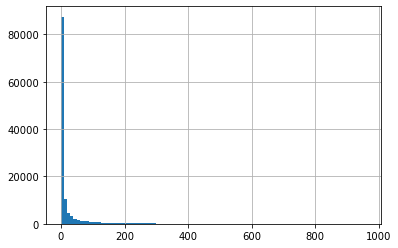

In [44]:
ratings = (user_df > 0).sum(axis=1)
ratings.hist(bins=100)
print('Min number of ratings: {}'.format(ratings.min()))
print('Max number of ratings: {}'.format(ratings.max()))

Min number of ratings per beer: 1339
Max number of ratings per beer: 17014


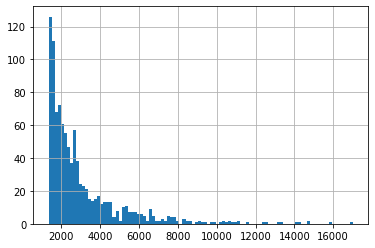

In [46]:
ratings = (user_df > 0).sum(axis=0)
ratings.hist(bins=100)
print('Min number of ratings per beer: {}'.format(ratings.min()))
print('Max number of ratings per beer: {}'.format(ratings.max()))

## Item-item similarity

In [18]:
C = user_df.corr(method='pearson')
C

beer_id,5,6,7,10,17,30,31,33,34,39,...,176650,178740,178857,181572,182256,187317,189272,197183,202078,211516
beer_id,,,,,,,,,,,,,,,,,,,,,
5,1.000000,0.396514,0.362809,0.135548,0.189042,0.209610,0.158081,0.180328,0.234565,0.042778,...,0.040047,0.122602,0.128708,0.136078,0.186302,0.059824,0.194907,0.233389,0.018292,-0.248655
6,0.396514,1.000000,0.335601,0.166223,0.104591,0.210728,0.174636,0.230641,0.205667,0.060788,...,0.198032,0.141873,0.118368,0.213663,0.225070,0.141215,0.004664,0.155348,0.054184,0.013006
7,0.362809,0.335601,1.000000,0.221463,0.114875,0.156428,0.139894,0.212844,0.163345,0.068495,...,0.197852,0.111625,0.066841,0.020049,0.114126,0.141685,0.148671,0.093420,0.106608,-0.019846
10,0.135548,0.166223,0.221463,1.000000,0.201709,0.237806,0.288063,0.206195,0.266174,0.062486,...,0.249097,0.160335,0.186535,0.234566,0.111401,0.124493,0.196380,0.243483,0.313579,0.138945
17,0.189042,0.104591,0.114875,0.201709,1.000000,-0.000743,0.077340,0.052049,0.077066,0.026984,...,-0.018616,0.117149,0.172438,0.073018,0.272184,0.141656,0.082455,0.063405,-0.043760,-0.117681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187317,0.059824,0.141215,0.141685,0.124493,0.141656,0.165143,0.264207,0.145651,0.168288,0.084362,...,0.207203,0.167478,0.178621,0.062868,0.289100,1.000000,0.090023,0.259249,0.111793,-0.037961
189272,0.194907,0.004664,0.148671,0.196380,0.082455,0.307736,0.186603,0.287306,0.169769,0.190603,...,0.297468,0.199954,0.280124,0.316723,0.185455,0.090023,1.000000,0.152499,0.342941,0.316266
197183,0.233389,0.155348,0.093420,0.243483,0.063405,0.123602,0.154480,0.078879,0.085523,0.064167,...,0.169512,0.325081,0.191846,0.186515,0.332074,0.259249,0.152499,1.000000,0.204989,0.177368


In [20]:
C.iloc[0].sort_values

<bound method Series.sort_values of beer_id
5         1.000000
6         0.396514
7         0.362809
10        0.135548
17        0.189042
            ...   
187317    0.059824
189272    0.194907
197183    0.233389
202078    0.018292
211516   -0.248655
Name: 5, Length: 1000, dtype: float64>

## User-User Similarity

In [85]:
user = user_df.iloc[0]
# similar_users(user)
ratings = (~user.isna())
# ratings.values
users_filt = user_df.T[ratings.values]
# users_filt
users_filt = users_filt.T.dropna(thresh=1)
# users_filt = users_filt.fillna(0)
users_filt


beer_id,5441,49789,52855
uid,,,
0,3.65,5.00,3.78
3,4.00,4.25,NaN
11,4.50,NaN,NaN
12,4.00,3.75,NaN
21,NaN,3.50,NaN
...,...,...,...
122226,3.75,3.50,NaN
122236,NaN,4.00,NaN
122248,NaN,5.00,NaN


In [24]:
U = np.corrcoef(users_filt)
np.argsort(U[0][~np.isnan(U[0])])[-6:-1]


array([ 56, 163, 164, 174, 138])

In [25]:
users_filt.iloc[56]

beer_id
412       4.00
779        NaN
11757     4.31
19960     4.16
38334      NaN
117177    3.95
Name: 2656, dtype: float64

In [122]:
users_filt.iloc[56]

beer_id
412       4.00
779        NaN
11757     4.31
19960     4.16
38334      NaN
117177    3.95
Name: 2656, dtype: float64

In [67]:
d = {412:5.,779:5.,38334:5.,117177:5.}
# updated_df = create_user_prof(user_df,d)
# np.reshape(d.values(),(4))
uid = user_df.shape[0]
updated_df = user_df.append(pd.DataFrame(d,index=[uid]))
updated_df



,5,6,7,10,17,30,31,33,34,39,...,176650,178740,178857,181572,182256,187317,189272,197183,202078,211516
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,3.25,NaN,NaN,3.25,4.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
user = updated_df.loc[uid]
ratings = (~user.isna())
users_filt = updated_df.T[ratings.values]
users_filt = users_filt.T.dropna(thresh=4)
#create pearson corr matrix
U = np.corrcoef(users_filt)
#find 5 most similar users
np.argsort(U[0][~np.isnan(U[0])])[-6:-1]

/home/tim/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/tim/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([170, 203,  87, 169, 190])

In [96]:
users_filt.iloc[203]

412       4.50
779       4.00
38334     4.50
117177    4.31
Name: 119367, dtype: float64

In [42]:
def create_user_prof(df, user_favs):
    '''
    Given a dictionary appends rows to the end of the user-ratings dataframe 

    Inputs -
    df: user-ratings dataframe
    user_favs: dictionary with beer_id as key and rating as values
    '''
    uid = df.shape[0]
    print(uid)
    for k,v in user_favs.items():
        df = df.append(pd.DataFrame(index=[uid],columns=[k],data=v))
    return df
    

In [99]:
def similar_users(uid, df, thresh=4):
    '''
    Based on current user rating, returns most similar users that rated one or more of the same beers.
    
    Inputs:
        uid - user id of new user
        df - user-ratings dataframe updated with new user
        thresh - threshold of number of rated beers in common for calculating similarities
    Returns:
        sim_users - array of most similar users ids
    '''
    user = df.loc[uid]
    ratings = (~user.isna())
    users_filt = df.T[ratings.values]
    users_filt = users_filt.T.dropna(thresh=thresh)
    #create pearson corr matrix
    U = np.corrcoef(users_filt)
    #find 5 most similar users
    sim_users = np.argsort(U[0][~np.isnan(U[0])])[-6:-1]
    return sim_users
    


In [101]:
similar_users(uid,updated_df)

/home/tim/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/tim/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([170, 203,  87, 169, 190])

In [31]:
U = csr_matrix(user_df)
U = compute_sparse_correlation_matrix(U)
U

<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in Compressed Sparse Column format>

In [16]:
ratings_mat.shape[0]

122277

To use Spark ALS, I need to convert usernames to user ids, because spark only accepts numerical values.

In [5]:
df['uid'] = df.groupby('username').ngroup()
df

,beer_id,username,score,count,uid
0,125646,_dirty_,4.50,2664,68954
1,125646,CJDUBYA,4.75,2664,11440
3,125646,LukeGude,4.31,2664,40001
4,125646,jneff33,4.91,2664,94165
5,125646,yummybeer,4.69,2664,121764
...,...,...,...,...,...
3078483,125646,Dopadosio,5.00,2664,19235
3078484,125646,willp27,4.95,2664,120752
3078485,125646,yoshie,4.60,2664,121706
3078486,125646,Davewm24,4.73,2664,17381


In [37]:
df[df.uid==68954]

,beer_id,username,score,count,uid
0,125646,_dirty_,4.50,2664,68954
71884,69522,_dirty_,4.28,1927,68954
103048,117177,_dirty_,4.50,5491,68954
159031,86237,_dirty_,4.56,4386,68954
680029,114804,_dirty_,5.00,2140,68954
1114993,85523,_dirty_,4.50,1530,68954
1337877,176650,_dirty_,4.08,2349,68954
1629757,111616,_dirty_,3.61,3753,68954
1686941,58299,_dirty_,4.42,2737,68954
1704953,127652,_dirty_,4.00,2089,68954


In [50]:
df.describe()

,Unnamed: 0,beer_id,score,count
count,3.046479e+06,3.046479e+06,3.046479e+06,3.046479e+06
mean,1.539764e+06,3.064399e+04,4.014147e+00,4.597233e+03
std,8.891001e+05,3.681308e+04,6.456568e-01,3.297014e+03
min,0.000000e+00,5.000000e+00,1.000000e+00,1.373000e+03
25%,7.695775e+05,1.331000e+03,3.750000e+00,2.181000e+03
50%,1.540104e+06,1.606200e+04,4.060000e+00,3.379000e+03
75%,2.310122e+06,5.050900e+04,4.500000e+00,5.998000e+03
max,3.078487e+06,2.115160e+05,5.000000e+00,1.716000e+04


In [5]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(df[['username','beer_id','score']],reader)

In [6]:
from surprise import SVD
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import BaselineOnly
from surprise import NMF

## SVD Model

In [8]:
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

In [10]:
user_factors = algo.pu
item_factors = algo.qi
item_factors.shape

(1000, 100)

In [12]:
item_factors[0]

array([ 5.14195989e-03, -1.41187812e-04, -6.78108970e-03, -1.38953487e-03,
        5.97139151e-03,  3.88018749e-03,  2.43771648e-02, -1.92315088e-03,
        4.85535923e-03, -1.94438581e-02,  2.33520027e-02, -3.89923972e-02,
       -3.40585000e-02,  1.19034666e-02,  3.69670050e-02,  9.53870418e-03,
        2.17726720e-03,  8.36945900e-03, -4.00476621e-02,  2.65633488e-02,
       -2.98443790e-02, -1.81880705e-02, -6.02290036e-03,  1.09048450e-02,
        2.02026503e-02,  1.81244655e-02, -2.21507175e-03,  1.70070991e-02,
        6.75086625e-03, -2.29342151e-02, -1.43902439e-03,  1.56247267e-02,
        1.67289710e-02,  1.15124502e-02,  5.49926934e-03,  1.32543889e-02,
        1.90131630e-02,  2.04717045e-02, -2.08857270e-02,  1.46151199e-02,
       -3.78475672e-02,  8.52188722e-03, -1.32809993e-02,  1.52785914e-02,
       -1.85413561e-02, -7.45046719e-03,  2.22467251e-02, -4.38554169e-02,
        3.58446951e-03, -3.21167946e-03, -1.22396364e-02, -1.61224858e-02,
       -1.78950091e-02,  

In [14]:
user_factors.shape

(122277, 100)

In [11]:
user_factors[0]

array([ 0.08807867,  0.00956693, -0.10186002, -0.02458415, -0.08766443,
       -0.09471607,  0.11608174,  0.00252638,  0.0769243 ,  0.17568412,
        0.08982521,  0.03021724,  0.09114156, -0.03127725, -0.1618958 ,
        0.09663218,  0.17944976, -0.13307959, -0.11846079,  0.00281378,
       -0.20193718, -0.01171689, -0.15065884, -0.17410169, -0.00263076,
        0.09914316,  0.08610399,  0.00791579, -0.03826057, -0.11641719,
       -0.08966695,  0.07725513, -0.06736369,  0.02882376,  0.00168645,
       -0.04906196, -0.03960369,  0.06188501, -0.05977469,  0.16481128,
        0.13778917,  0.01217032, -0.08302664, -0.05873052, -0.01687506,
        0.00572285,  0.00886217,  0.12866568, -0.247582  , -0.07567914,
       -0.10827145, -0.10049458, -0.27410926, -0.07499691, -0.00753191,
        0.03551999,  0.05709049, -0.0920533 ,  0.038797  , -0.06026596,
       -0.00043544,  0.12241009,  0.13074651,  0.0623946 , -0.04544035,
       -0.0090502 , -0.02769028,  0.12385887,  0.0095382 , -0.13

In [17]:
R = np.dot(user_factors,item_factors.T)
R.shape

(122277, 1000)

In [27]:
R[0][:10]

array([ 0.00239127,  0.0466325 , -0.03705181,  0.02308247, -0.04192398,
       -0.01390285,  0.03072849, -0.11168718, -0.02379033, -0.02327893])

In [26]:
np.argmax(R[0])

152

## Use K-fold to find best model

In [27]:
classes = [BaselineOnly, NormalPredictor, SVD, NMF]
table=[]
for algo in tqdm(classes):
    out = cross_validate(algo(), data, cv=3)
    mean_rmse = '{:.3f}'.format(np.mean(out['test_rmse']))
    new_line = [algo.__name__,mean_rmse]
    print(new_line)
    table.append(new_line)
table

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


 25%|██▌       | 1/4 [01:05<03:17, 65.78s/it]

['BaselineOnly', '0.433']


 50%|█████     | 2/4 [02:10<02:10, 65.32s/it]

['NormalPredictor', '0.889']


 75%|███████▌  | 3/4 [08:04<03:17, 197.11s/it]

['SVD', '0.436']


100%|██████████| 4/4 [14:28<00:00, 217.14s/it]

['NMF', '0.463']


[['BaselineOnly', '0.433'],
 ['NormalPredictor', '0.889'],
 ['SVD', '0.436'],
 ['NMF', '0.463']]

## Comparing Surpise models to Spark ALS method

In [6]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [7]:
# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder \
            .master("local[*]") \
            .config("spark.driver.memory", "15g") \
            .appName("BeerBro") \
            .getOrCreate()
sc = spark.sparkContext
spark, sc

(<pyspark.sql.session.SparkSession at 0x7fa814152f40>,
 <SparkContext master=local[*] appName=BeerBro>)

In [8]:
# schema = StructType([
#     StructField("user", StringType(), True),
#     StructField("beer", IntegerType(), True),
#     StructField("score", IntegerType(), True),
#     StructField("count", IntegerType(), True)
#     ])



df_ratings = spark.createDataFrame(df)
df_ratings.show(5)

+-------+---------+-----+-----+------+
|beer_id| username|score|count|   uid|
+-------+---------+-----+-----+------+
| 125646|  _dirty_|  4.5| 2664| 68954|
| 125646|  CJDUBYA| 4.75| 2664| 11440|
| 125646| LukeGude| 4.31| 2664| 40001|
| 125646|  jneff33| 4.91| 2664| 94165|
| 125646|yummybeer| 4.69| 2664|121764|
+-------+---------+-----+-----+------+
only showing top 5 rows



In [33]:
print('Number of unique users: {}'.format(df_ratings.select('uid').distinct().count()))
print('Number of unique beers: {}'.format(df_ratings.select('beer_id').distinct().count()))
print('Number of rating: {}'.format(df_ratings.count()))

Number of unique users: 122277
Number of unique beers: 1000
Number of rating: 3046479


In [9]:
train,test = df_ratings.randomSplit([0.8,0.2])
als = ALS(userCol='uid',
                itemCol='beer_id',
                ratingCol='score',
                nonnegative=True,
                implicitPrefs=False,
                coldStartStrategy='drop'
               )


In [10]:
#create hyperparmater grid for cross validation
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10,50,100]) \
            .addGrid(als.regParam, [.01,.05,.1]) \
            .build()

In [11]:
evaluator = RegressionEvaluator(
            metricName='rmse',
            labelCol='score',
            predictionCol='prediction')
len(param_grid)

9

In [12]:
#create cross validator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid,
                evaluator=evaluator, numFolds=3)

In [13]:
#Fit cross validator to the 'train' dataset
model = cv.fit(train)   #Extract best model from the cv model above
best_model = model.bestModel    # View the predictions
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.46593362981140707


In [11]:
cross_validate(NormalPredictor(),data,cv=2)

{'test_rmse': array([1.8562683 , 1.43975082]),
 'test_mae': array([0.69394968, 1.1423621 ]),
 'fit_time': (2.19085693359375, 2.6427297592163086),
 'test_time': (15.031850337982178, 15.018870830535889)}

In [14]:
cross_validate(SVD(),data,cv=2)

{'test_rmse': array([1.17831152, 1.68690022]),
 'test_mae': array([0.98580954, 0.30880911]),
 'fit_time': (76.11983704566956, 75.62216782569885),
 'test_time': (14.427448987960815, 15.676785230636597)}

In [19]:
param_grid = {'n_epochs': [10,20], 'lr_all': [0.001,0.002],
              'reg_all': [0.4, 0.5,0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

In [20]:
gs.fit(data)

In [21]:
gs.best_score['rmse']

0.9934610923443413

In [22]:
gs.best_params['rmse']

{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}

In [23]:
algo = gs.best_estimator['rmse']

In [74]:
trainset, testset = train_test_split(data, test_size=0.25)
predictions = algo.fit(trainset).test(testset)

In [75]:
accuracy.rmse(predictions)

RMSE: 0.4665


0.46654713198469905

In [77]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
pred_df = pd.DataFrame(predictions, columns=['username', 'beer_id', 'rui', 'est', 'details'])
pred_df['Iu'] = pred_df.username.apply(get_Iu)
pred_df['Ui'] = pred_df.beer_id.apply(get_Ui)
pred_df['err'] = abs(pred_df.est - df.rui)
best_predictions = pred_df.sort_values(by='err')[:10]
worst_predictions = pred_df.sort_values(by='err')[-10:]

In [57]:
pred_df.describe()

,beer_id,rui,est,Iu,Ui,err
count,761620.000000,761620.000000,761620.000000,761620.000000,761620.000000,761620.000000
mean,30591.157397,4.014412,4.034786,152.280740,3415.753943,0.330182
std,36781.662466,0.644893,0.329553,138.635255,2447.544818,0.329513
min,5.000000,1.000000,1.000000,0.000000,986.000000,0.000000
25%,1331.000000,3.750000,3.893115,40.000000,1617.000000,0.108798
50%,15881.000000,4.060000,4.091898,114.000000,2523.000000,0.240682
75%,50509.000000,4.500000,4.244886,230.000000,4476.000000,0.447292
max,211516.000000,5.000000,5.000000,726.000000,12671.000000,4.000000


In [78]:
best_predictions

,username,beer_id,rui,est,details,Iu,Ui,err
701794,toomuchhops,50772,4.50,5.000000,{'was_impossible': False},120,2165,0.000000e+00
153231,wyckydsceptre,50772,4.25,5.000000,{'was_impossible': False},33,2165,0.000000e+00
513305,gigaknight,50772,4.82,5.000000,{'was_impossible': False},14,2165,0.000000e+00
183734,OldManBike,6322,3.75,4.000000,{'was_impossible': False},65,2293,3.753277e-07
653976,akelmore,6260,4.00,3.999998,{'was_impossible': False},2,4938,1.553949e-06
305158,wordemupg,66507,3.55,3.919998,{'was_impossible': False},325,1184,2.291289e-06
379887,TrudiiSchu,132073,4.55,4.000004,{'was_impossible': False},1,1328,3.523446e-06
233568,rangerred,98383,4.40,3.999995,{'was_impossible': False},349,1690,5.010795e-06
119065,ColdPoncho,2093,4.20,4.250005,{'was_impossible': False},186,11796,5.405297e-06
171871,GMorgan,58610,4.31,4.250006,{'was_impossible': False},175,2156,5.856386e-06


In [79]:
worst_predictions

,username,beer_id,rui,est,details,Iu,Ui,err
36992,mrjmann,7971,3.75,4.666856,{'was_impossible': False},99,11006,3.666856
631522,sjstraub,3659,5.00,4.668764,{'was_impossible': False},180,1345,3.668764
485211,starshockey9,50772,4.00,1.000000,{'was_impossible': False},53,2165,3.710000
520390,CEDAMA,38180,5.00,4.714184,{'was_impossible': False},268,5134,3.714184
412718,dpgoblejr,16814,4.93,4.735764,{'was_impossible': False},326,10653,3.735764
220335,aranton,50772,4.50,1.046254,{'was_impossible': False},112,2165,3.953746
137691,hombrepalo,50772,3.75,1.000000,{'was_impossible': False},104,2165,4.000000
622170,buyBinboaVodka,50772,4.87,1.000000,{'was_impossible': False},14,2165,4.000000
462060,Skunkyluvmuffin,50772,4.50,1.000000,{'was_impossible': False},120,2165,4.000000
58691,CaptainFantasy,50772,4.50,1.000000,{'was_impossible': False},3,2165,4.000000


In [ ]:
#save model as binary
# dump.dump('../model/model',algo=algo,verbose=1)

In [65]:
beer_df = pd.read_csv('../data/beers.csv')

In [80]:
df.loc[df.beer_id==6322]

,username,beer_id,rui,est,details,Iu,Ui,err
810,beep71,6322,4.42,3.973458,{'was_impossible': False},20,2342,0.484586
859,Samp01,6322,4.10,3.896082,{'was_impossible': False},183,2342,0.755403
6150,RedneckBeerz,6322,4.25,4.019446,{'was_impossible': False},298,2342,0.282483
6327,ROGUE16,6322,4.00,3.948809,{'was_impossible': False},379,2342,0.383734
6366,jholland,6322,3.75,3.906415,{'was_impossible': False},54,2342,0.197064
...,...,...,...,...,...,...,...,...
756931,mkholmes25,6322,4.02,3.993962,{'was_impossible': False},26,2342,0.156796
756992,Reagan1984,6322,4.31,3.992799,{'was_impossible': False},428,2342,0.688280
758514,Number3red,6322,3.50,4.041398,{'was_impossible': False},141,2342,1.054525
758887,neenerzig,6322,4.03,4.112690,{'was_impossible': False},246,2342,0.919368


## Content Based Filtering

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
df = pd.read_csv('../data/beer_features.csv')
df

,Unnamed: 0,beer_id,text,look,smell,taste,feel,score,name,brewery_id,state,country,style,abv,notes
0,0,5,"Beautiful beer. Light and tasty., I trave...",3.569071,3.314848,3.435774,3.401786,3.459699,Amber,3,LA,US,Vienna Lager,4.5,Amber is a Munich style lager brewed with crys...
1,1,6,"great brown ale...one of my favorites., M...",3.837863,3.575499,3.684462,3.587068,3.659804,Turbodog,3,LA,US,English Brown Ale,5.6,Turbodog is a dark brown ale brewed with Willa...
2,2,7,The labeling with the purple haze guy with ...,3.407776,3.328253,3.254259,3.264490,3.289541,Purple Haze,3,LA,US,Fruit and Field Beer,4.2,Experience the magic of Purple Haze.® Clouds o...
3,3,10,Pours slightly hazy deep amber/brown. 1 fin...,3.935979,5.871466,3.796924,3.783938,3.805655,Dubbel Ale,4,ME,US,Belgian Dubbel,7.0,Allagash Dubbel boasts a deep red color and a ...
4,4,17,"0%, Not much like a hefe, too citrusy (or...",3.479105,3.211594,3.255258,3.344787,3.322062,Widmer Hefeweizen,8,OR,US,German Hefeweizen,4.9,availability: year-round
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,187317,I think a one is to high of a rating. I per...,3.745092,3.618064,3.698520,3.706631,3.681254,Otra Vez,140,CA,US,Leipzig Gose,4.5,"In California, where temperatures often top tr..."
996,996,189272,"Love this beer., 19.2 oz can , 10/30/17, ...",4.534134,4.448494,4.485783,4.485113,4.477996,Ten FIDY - Bourbon Barrel Aged,2681,CO,US,Russian Imperial Stout,12.9,Aged through four seasons and from a blend of ...
997,997,197183,Clear Amber pour with modest head. Aromas o...,3.862383,3.868740,3.826301,3.780224,3.833175,Citradelic Tangerine IPA,192,CO,US,American IPA,6.0,"Tangerine IPA brewed with Citra hops, orange p..."
998,998,202078,""" Bought beer, poured a glass, it looked too...",4.295023,4.355418,4.342755,4.280097,4.331283,Enjoy By Unfiltered IPA,147,CA,US,American Imperial IPA,9.4,In most cases skipping a step is a bad thing. ...


In [22]:
# df[((df['style']=='American IPA')&(df['state']=='CO'))] 
df[df['beer_id']==5]

,Unnamed: 0,beer_id,text,look,smell,taste,feel,score,name,brewery_id,state,country,style,abv,notes
0,0,5,"Beautiful beer. Light and tasty., I trave...",3.569071,3.314848,3.435774,3.401786,3.459699,Amber,3,LA,US,Vienna Lager,4.5,Amber is a Munich style lager brewed with crys...


In [24]:
df[df['beer_id']==7]

,Unnamed: 0,beer_id,text,look,smell,taste,feel,score,name,brewery_id,state,country,style,abv,notes
2,2,7,The labeling with the purple haze guy with ...,3.407776,3.328253,3.254259,3.26449,3.289541,Purple Haze,3,LA,US,Fruit and Field Beer,4.2,Experience the magic of Purple Haze.® Clouds o...


In [20]:
tf = TfidfVectorizer(analyzer='word', ngram_range = (1,2),max_features=10000, stop_words='english')

In [21]:
X = tf.fit_transform(df.text)

In [22]:
X.shape

(1000, 10000)

In [23]:
cosine_sims = cosine_similarity(X,X)

In [24]:
results={}

In [25]:
for idx, row in df.iterrows():
    sim_indices = cosine_sims[idx].argsort()[-12:-1]
    sim_items = [(cosine_sims[idx][i], df['beer_id'][i]) for i in sim_indices]
    results[row['beer_id']] = sim_items[1:]
    

In [54]:
n=5
sim_beers = results[9689][:n-1:-1]
names=[]
breweries=[]
styles=[]
scores=[]
abvs=[]
notes=[]
states=[]
countries=[]
for i, row in enumerate(sim_beers):
    beer = df[df['beer_id']==row[1]]
    names.append(beer.name.iloc[0])
    breweries.append(beer.brewery_id.iloc[0])
    styles.append(beer['style'].iloc[0])
    scores.append(beer['score'].iloc[0])
    abvs.append(beer['abv'].iloc[0])
    notes.append(beer['notes'].iloc[0])
    states.append(beer['state'].iloc[0])
    countries.append(beer['country'].iloc[0])
d = {'name':names,'brewery':breweries,'style':styles,'rating':scores,
            'abv':abvs, 'description':notes,'state':states,'country':countries}
new_df = pd.DataFrame(d)
new_df

    

,name,brewery,style,rating,abv,description,state,country
0,White,4,Belgian Witbier,4.157047,5.1,Our interpretation of a traditional Belgian wh...,ME,US
1,Witte Wheat Ale,42,Belgian Witbier,3.763665,5.2,Witte is our version of the classic Belgian wi...,NY,US
2,Hitachino Nest White Ale,697,Belgian Witbier,4.068154,5.5,No notes at this time.,NaN,JP
3,Blanche De Chambly,22,Belgian Witbier,3.893366,5.0,The Blanche de Chambly label features the icon...,QC,CA
4,Witbier,259,Belgian Witbier,4.160018,5.5,No notes at this time.,NaN,BE


In [130]:
breweries = pd.read_csv('../data/breweries.csv')

In [143]:
breweries[breweries['name'].str.contains('Crooked Stave')].id

35818    25191
Name: id, dtype: int64

In [134]:
df[df['beer_id']==7879]

,Unnamed: 0,beer_id,text,look,smell,taste,feel,score,name,brewery_id,state,country,style,abv,notes
391,391,7879,"Seen this one everywhere, so I finally cave...",4.113344,4.090426,4.150638,4.107481,4.160018,Witbier,259,NaN,BE,Belgian Witbier,5.5,No notes at this time.


In [55]:
# df[df['brewery_id']==25191]
# df[(df['name'].str.contains('IPA'))&(df['brewery_id']==147)]
df[(df['name'].str.contains('IPA'))]

,Unnamed: 0,beer_id,text,look,smell,taste,feel,score,name,brewery_id,state,country,style,abv,notes
17,17,88,"0%, This is not as great as people seem t...",4.130765,4.177876,4.220225,4.128217,4.203125,IPA,147,CA,US,American IPA,6.9,The IPA That Launched Generations of Hop Fanatics
46,46,205,"Pours amber, hazy with a very mild white fo...",3.745269,4.798729,3.546697,3.550865,3.570461,Snake Dog IPA,68,MD,US,American IPA,7.1,No notes at this time.
68,68,311,Copper color with a white foamy head Aroma:...,3.714050,3.586856,3.638321,3.626334,3.624594,IPA,98,MA,US,English India Pale Ale (IPA),5.9,We started brewing this beer as a summer seaso...
101,101,611,"This West Coast IPA felt good, lot of balan...",4.075748,3.951638,4.004534,3.944496,3.984269,Hop Ottin' IPA,193,CA,US,American IPA,7.0,Our Hop Ottin’ IPA is brewed and dry-hopped wi...
155,155,916,"Look: Amber, clear Smell: Light hops, citru...",3.904583,3.850462,3.901053,3.852267,3.891691,Lagunitas IPA,220,CA,US,American IPA,6.2,Thanks for choosing to spend the next few minu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,987,162643,Bottle from Total Wine & More in Boynton Be...,3.988949,3.888978,3.890415,3.890785,3.897661,Azacca IPA,1199,MI,US,American IPA,7.0,"Named for the Haitian god of agriculture, the ..."
988,988,168971,"hoppy for sure., I like Stone Brewing Dou...",4.193721,4.208760,4.248721,4.184362,4.225271,Ruination Double IPA 2.0,147,CA,US,American Imperial IPA,8.5,A Liquid Poem to the Glory of the Hop
994,994,182256,Beer poured into a pint glass from a bottle...,3.972147,3.941325,3.940556,3.903667,3.934917,Beer Camp: Tropical IPA (2016),140,CA,US,New England IPA,6.7,No notes at this time.
997,997,197183,Clear Amber pour with modest head. Aromas o...,3.862383,3.868740,3.826301,3.780224,3.833175,Citradelic Tangerine IPA,192,CO,US,American IPA,6.0,"Tangerine IPA brewed with Citra hops, orange p..."


In [58]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
column_trans = ColumnTransformer(
    [('cat_features',OneHotEncoder(dtype='int'),['state','country','style']),
    ('num_features', )
    (('text_bow',tf,'text')]
)